## 6.3.1 替换线性模型

In [2]:
import torch
from torch import optim
import torch.nn as nn
from collections import OrderedDict

In [14]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [3]:
seq_model = nn.Sequential(nn.Linear(1, 13),  # 输入维度1，输出维度13，但是还需要提供输入张量的批次，因此需要给原始数据加一个维度
                          nn.Tanh(),
                          nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

## 6.3.2 检查参数

In [4]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [5]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [6]:
seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(1, 8)),
                                        ('hidden_activation', nn.Tanh()),
                                        ('output_linear', nn.Linear(8, 1))]))
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [12]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2153], requires_grad=True)

In [16]:
def train_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 100 == 0:
            print(f"Epoch {epoch}, Train loss {loss_train.item():.4f}, Val loss {loss_val.item():.4f}")

In [17]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
train_loop(5000, optimizer, seq_model, nn.MSELoss(), t_un_train, t_un_val, t_c_train, t_c_val)

Epoch 1, Train loss 197.1283, Val loss 67.7587
Epoch 100, Train loss 80.6458, Val loss 6.0579
Epoch 200, Train loss 53.3540, Val loss 8.0249
Epoch 300, Train loss 31.5709, Val loss 9.8198
Epoch 400, Train loss 17.9160, Val loss 11.2893
Epoch 500, Train loss 11.4564, Val loss 11.9606
Epoch 600, Train loss 8.6485, Val loss 11.9073
Epoch 700, Train loss 7.2005, Val loss 11.5329
Epoch 800, Train loss 6.2628, Val loss 11.0534
Epoch 900, Train loss 5.5586, Val loss 10.5402
Epoch 1000, Train loss 4.9885, Val loss 10.0204
Epoch 1100, Train loss 4.5096, Val loss 9.5068
Epoch 1200, Train loss 4.0998, Val loss 9.0059
Epoch 1300, Train loss 3.7454, Val loss 8.5204
Epoch 1400, Train loss 3.4375, Val loss 8.0526
Epoch 1500, Train loss 3.1700, Val loss 7.6093
Epoch 1600, Train loss 3.8443, Val loss 14.1553
Epoch 1700, Train loss 4.8633, Val loss 18.4419
Epoch 1800, Train loss 4.4717, Val loss 16.9990
Epoch 1900, Train loss 4.1415, Val loss 15.7607
Epoch 2000, Train loss 3.8499, Val loss 14.6483
Epoch

#  6.3.3 与线性模型对比

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

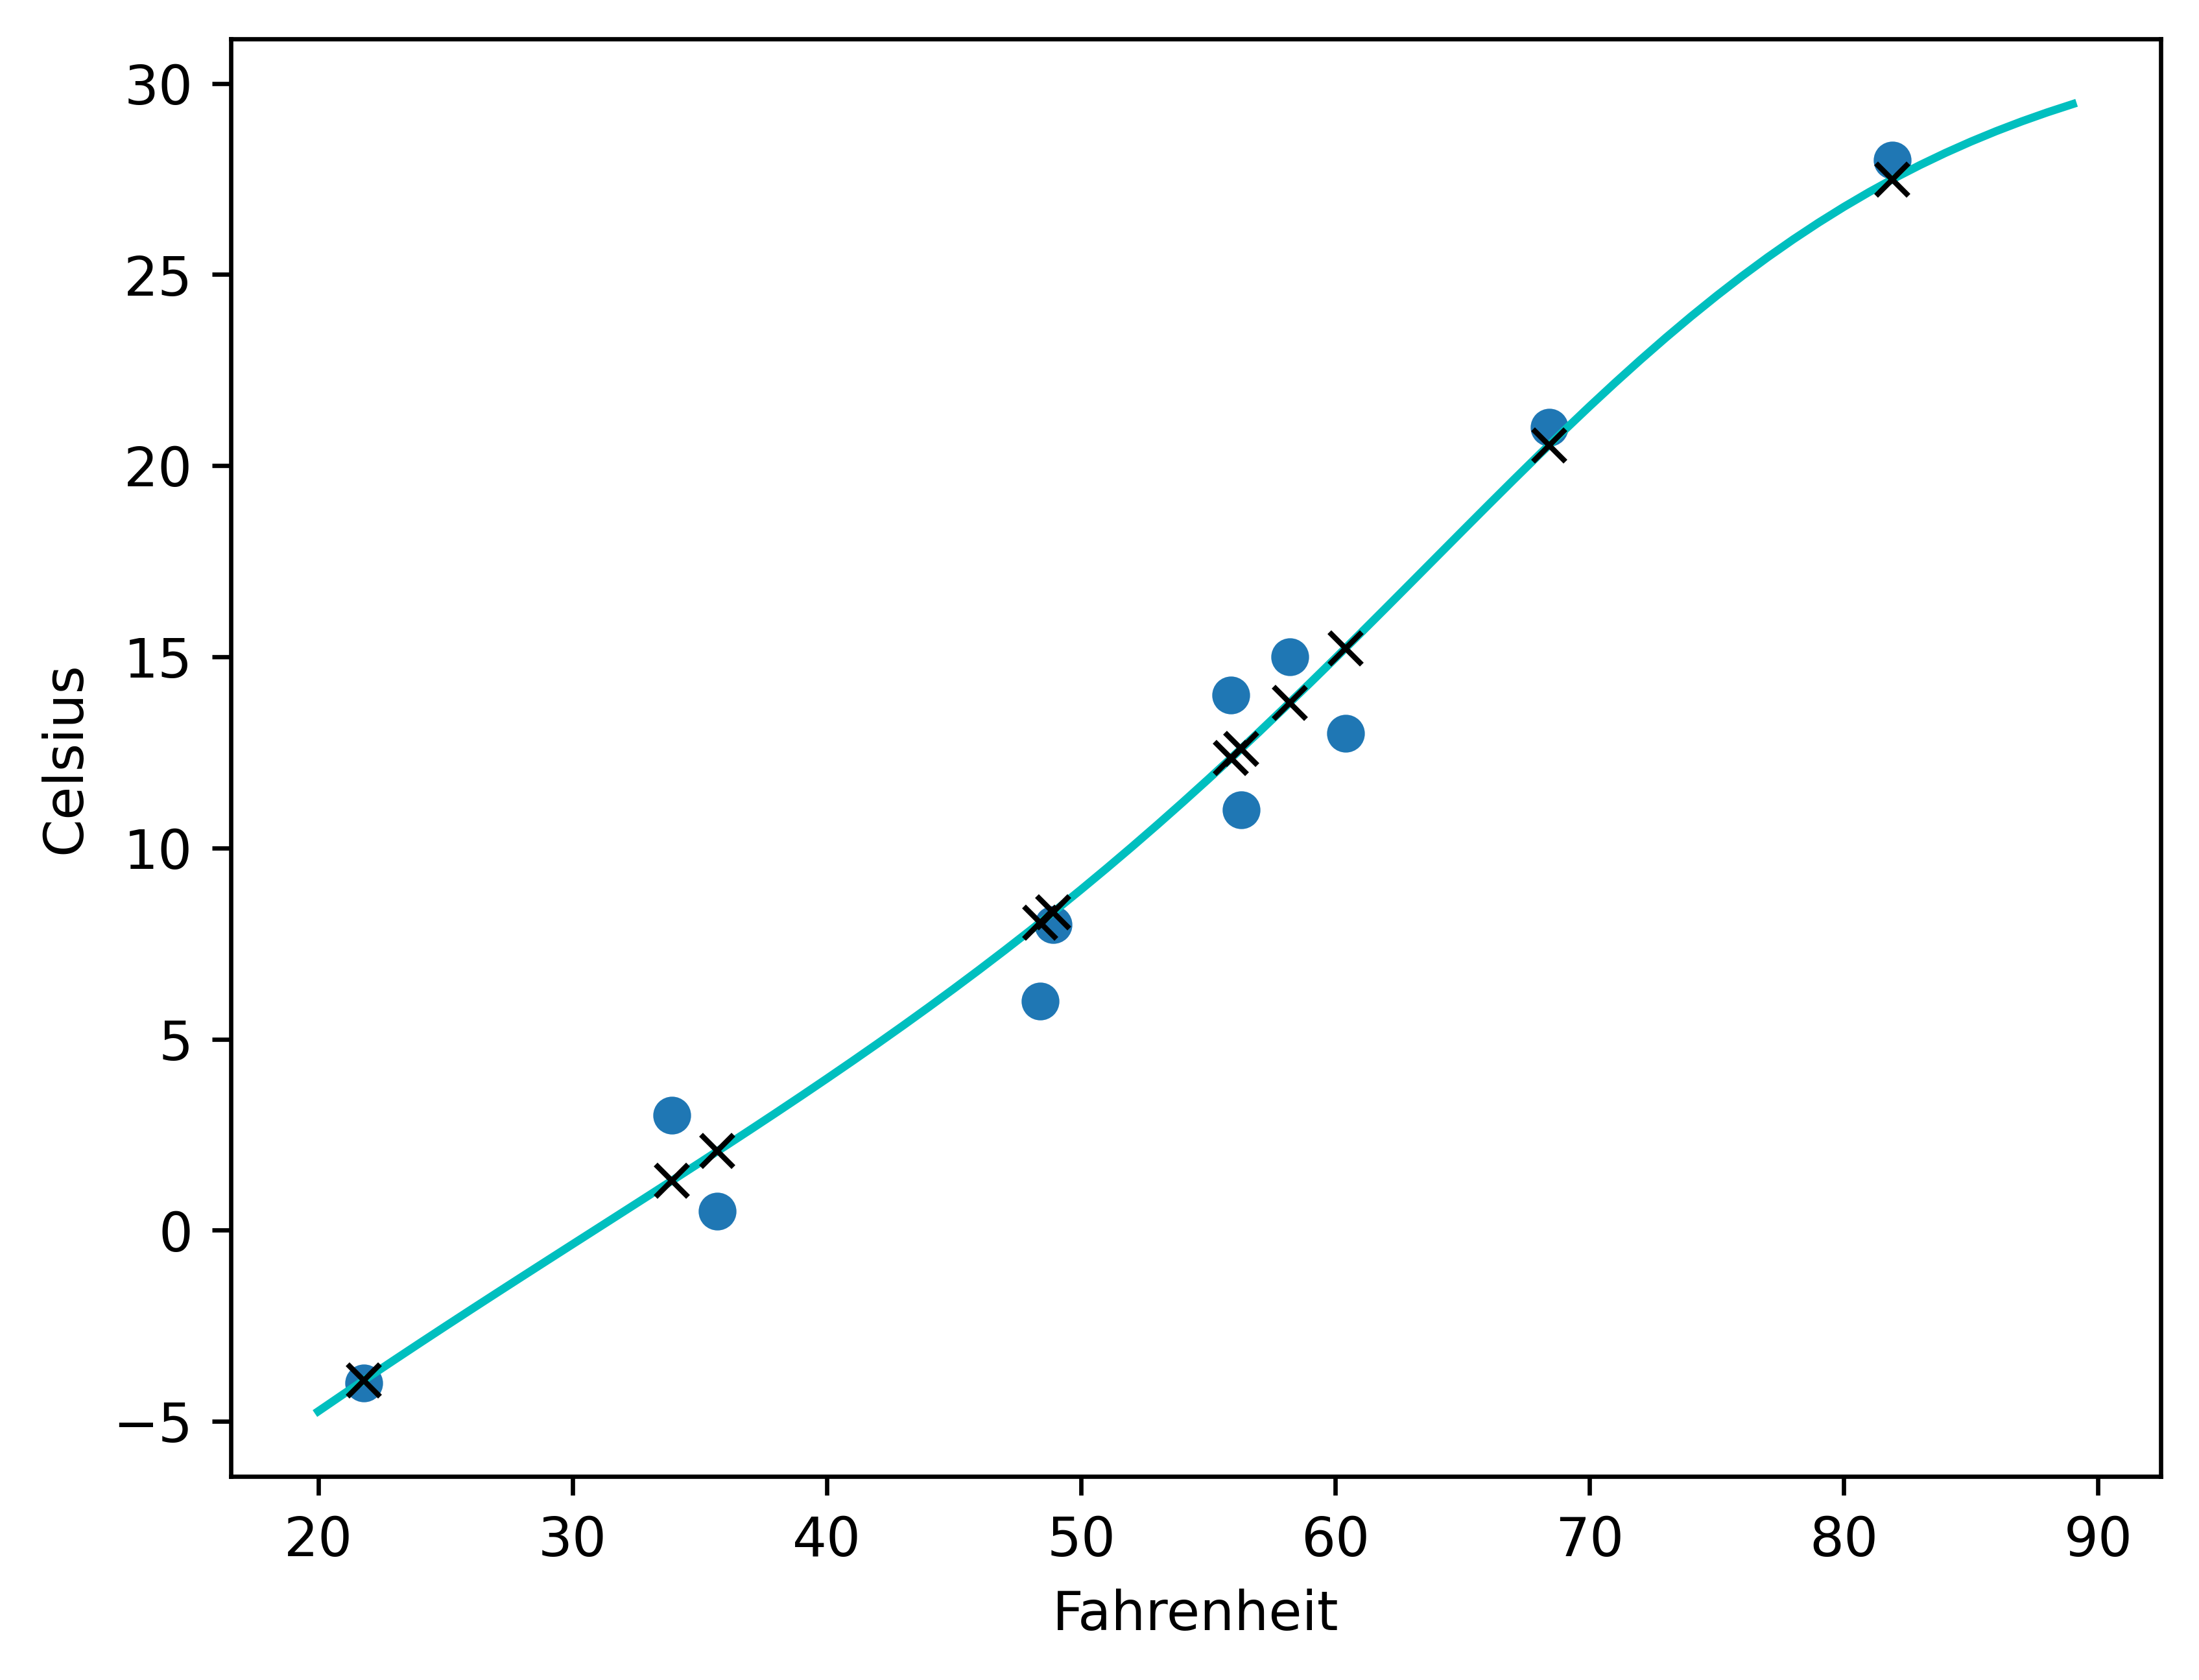

In [21]:
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
fig